In [2]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler  
from imblearn.under_sampling import RandomUnderSampler 


### 数据处理：欠采样+过采样

In [3]:
data1 = pd.read_csv('./data/processed_data/PGT121.csv')
data1 = data1[data1["label"]!=2]

len(data1)


1251

In [70]:
data2 = pd.read_csv('./data/processed_data/VRC01.csv')
data2 = data2[data2["label"]!=2]

len(data2)

963

In [71]:
data3 = pd.read_csv('./data/processed_data/3BNC117.csv')
data3 = data3[data3["label"]!=2]

len(data3)

943

In [72]:
data4 = pd.read_csv('./data/processed_data/10-1074.csv')
data4 = data4[data4["label"]!=2]

len(data4)

987

In [73]:
data5 = pd.read_csv('./data/processed_data/2F5.csv')
data5 = data5[data5["label"]!=2]

len(data5)

609

In [53]:
data = pd.read_csv('./data/antibody/merge2_5label.csv')

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.7, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [54]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.GP120.values
        eval_data = df_eval.GP120.values
        
        train_label_1 = df_training.PGT121_label.values
        train_label_2 = df_training.VRC01_label.values

        eval_label_1 = df_eval.PGT121_label.values
        eval_label_2 = df_eval.VRC01_label.values

        self.data = train_data if train else eval_data
        self.label_1 = train_label_1 if train else eval_label_1
        self.label_2 = train_label_2 if train else eval_label_2
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 500)
        #获取label
        label_1 = self.label_1[index]
        label_2 = self.label_2[index]
        return sequence, label_1, label_2
    
    def __len__(self):
        return len(self.data)
    

def collate_fn(batch):
    sequence, label_1, label_2 = zip(*batch)
    content = [i for i in sequence]
    content = torch.FloatTensor(content)
    label_1 = torch.FloatTensor(label_1)
    label_2 = torch.FloatTensor(label_2)
    return content, label_1, label_2


def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader


# for index, (input, target) in enumerate(get_dataloader(train=False)):
    
#     break
    

In [55]:
# 将数据和标签处理成张量
def Seq_tensor(seq_list, is_seq=True):
    tensor = []
    if is_seq:
        for seq in seq_list:
            data = transform(seq, 500)
            tensor.append(data)
        tensor = torch.LongTensor(tensor)
    else:
        tensor = torch.LongTensor(seq_list)
    return tensor

In [56]:
# Training data
# Task1
X_task1 = Seq_tensor(df_training.GP120.values, True)
y_task1 = Seq_tensor(df_training["PGT121_label"].to_list(), False)

# Task2
y_task2 = Seq_tensor(df_training["VRC01_label"].to_list(), False)

# Task3
y_task3 = Seq_tensor(df_training["3BNC117_label"].to_list(), False)

# Task4
y_task4 = Seq_tensor(df_training["10-1074_label"].to_list(), False)

# Task5
y_task5 = Seq_tensor(df_training["2F5_label"].to_list(), False)



/tmp/ipykernel_106745/4244298331.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tensor = torch.LongTensor(seq_list)


In [57]:
# Testing data
# Task1
X_test1 = Seq_tensor(df_eval.GP120.values, True)
y_test1 = Seq_tensor(df_eval["PGT121_label"].to_list(), False)

# Task2
y_test2 = Seq_tensor(df_eval["VRC01_label"].to_list(), False)

# Task3
y_test3 = Seq_tensor(df_eval["3BNC117_label"].to_list(), False)

# Task4
y_test4 = Seq_tensor(df_eval["10-1074_label"].to_list(), False)

# Task5
y_test5 = Seq_tensor(df_eval["2F5_label"].to_list(), False)



/tmp/ipykernel_106745/4244298331.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tensor = torch.LongTensor(seq_list)


In [58]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, num_tasks, dropout):
        super(MultiTaskClassifier, self).__init__()
        self.shared_layers1 = nn.Sequential(
            # Embedding层
            nn.Embedding(input_size, hidden_size),
            # Transformer编码器
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
                num_layers )
        )
        self.shared_layers2 = nn.Sequential(
            nn.Linear(hidden_size, 64),  # Shared hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),         # Shared hidden layer
            nn.ReLU()
        )
        self.classifiers = nn.ModuleList([nn.Linear(32, 2) for _ in range(num_tasks)])

    def forward(self, x):
        x = self.shared_layers1(x)
        # 平均池化
        x = torch.mean(x, dim=1)
        x = self.shared_layers2(x)
        outputs = [classifier(x) for classifier in self.classifiers]
        return outputs


In [59]:
num_tasks = 5  # Number of binary classification tasks
input_size = len(vocabulary)
hidden_size = 64
num_heads = 4
num_layers = 3
dropout = 0.1
# Instantiate the model
model = MultiTaskClassifier(input_size, hidden_size, num_heads, num_layers, num_tasks, dropout).to(device)

# Define loss functions and optimizers for each task
# criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(classifier.parameters(), lr=0.01) for classifier in model.classifiers]

# load model
if os.path.exists("./model/MT/multi_task.pkl"):
    model.load_state_dict(torch.load("./model/MT/multi_task.pkl"))
    optimizers.load_state_dict(torch.load("./model/MT/MT_optimizer.pkl"))

In [60]:
# Define hyperparameters
num_epochs = 3000
batch_size = 16

# Combine data for all tasks into one DataLoader (you might need to adapt this based on your data)
dataset = TensorDataset(X_task1, y_task1, y_task2, y_task3, y_task4, y_task5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_file = pd.DataFrame(columns=['epoch_num', 'loss_task1', 'loss_task2', 'loss_task3', 'loss_task4', 'loss_task5', 'loss_mean'])
# Training loop
for epoch in range(num_epochs):
    loss_list1, loss_list2, loss_list3, loss_list4, loss_list5 = [],[],[],[],[] # record loss of 5 tasks respectively
    loss_mean = None #record even loss of 5 tasks
    for batch in loader:
        # Split data into inputs and labels for each task
        X_task1, y_task1, y_task2, y_task3, y_task4, y_task5 = batch
       
        X_task1 = X_task1.to(device)

        y_task1 = y_task1.to(device)
        y_task2 = y_task2.to(device)
        y_task3 = y_task3.to(device)
        y_task4 = y_task4.to(device)
        y_task5 = y_task5.to(device)
        

        # Zero the gradients for all optimizers
        for optimizer in optimizers:
            optimizer.zero_grad()

        # Forward pass and backward pass for each task
        outputs_task1 = model(X_task1)
        loss_task1 = criterion(outputs_task1[0], y_task1)  # Assuming the first classifier corresponds to task 1
        loss_task1.backward()
        optimizers[0].step()
        loss_list1.append(loss_task1.item())

        # Repeat for tasks 2 to 5
        # ...
        outputs_task2 = model(X_task1)
        loss_task2 = criterion(outputs_task2[1], y_task2)  # Assuming the first classifier corresponds to task 2
        loss_task2.backward()
        optimizers[1].step()
        loss_list2.append(loss_task2.item())

        outputs_task3 = model(X_task1)
        loss_task3 = criterion(outputs_task3[2], y_task3)  # Assuming the first classifier corresponds to task 3
        loss_task3.backward()
        optimizers[2].step()
        loss_list3.append(loss_task3.item())

        outputs_task4 = model(X_task1)
        loss_task4 = criterion(outputs_task4[3], y_task4)  # Assuming the first classifier corresponds to task 4
        loss_task4.backward()
        optimizers[3].step()
        loss_list4.append(loss_task4.item())

        outputs_task5 = model(X_task1)
        loss_task5 = criterion(outputs_task5[4], y_task5)  # Assuming the first classifier corresponds to task 5
        loss_task5.backward()
        optimizers[4].step()
        loss_list5.append(loss_task5.item())

        loss_mean = mean(loss_list1+loss_list2+loss_list3+loss_list4+loss_list5)
    
    # record all loss value
    loss_dic = {
        "epoch_num": epoch+1,
        "loss_task1": mean(loss_list1),
        "loss_task2": mean(loss_list2),
        "loss_task3": mean(loss_list3),
        "loss_task4": mean(loss_list4),
        "loss_task5": mean(loss_list5),
        "loss_mean": loss_mean,
    }
    loss_dic = pd.Series(loss_dic)
    loss_file = loss_file._append(loss_dic, ignore_index = True)

    # Save models every 10 epochs
    # if (epoch + 1) % 10 == 0:
    #     torch.save(model.state_dict(), "./model/MT/multi_task.pkl")
    #     torch.save(optimizers.state_dict(), "./model/MT/MT_optimizer.pkl")
    
    # Print the loss every 10 epochs0
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss (Task 1): {(mean(loss_list1)):.4f}, Loss (Task 2): {(mean(loss_list2)):.4f}, Loss (Task 3): {(mean(loss_list3)):.4f}, Loss (Task 4): {(mean(loss_list4)):.4f}, Loss (Task 5): {(mean(loss_list5)):.4f}, Even Loss: {loss_mean:.4f}')


Epoch [1000/3000], Loss (Task 1): 0.6467, Loss (Task 2): 0.4251, Loss (Task 3): 0.4593, Loss (Task 4): 0.6252, Loss (Task 5): 0.4241, Even Loss: 0.5161
Epoch [2000/3000], Loss (Task 1): 0.6368, Loss (Task 2): 0.4265, Loss (Task 3): 0.4640, Loss (Task 4): 0.6157, Loss (Task 5): 0.3972, Even Loss: 0.5080
Epoch [3000/3000], Loss (Task 1): 0.6348, Loss (Task 2): 0.4249, Loss (Task 3): 0.4661, Loss (Task 4): 0.5912, Loss (Task 5): 0.3329, Even Loss: 0.4900


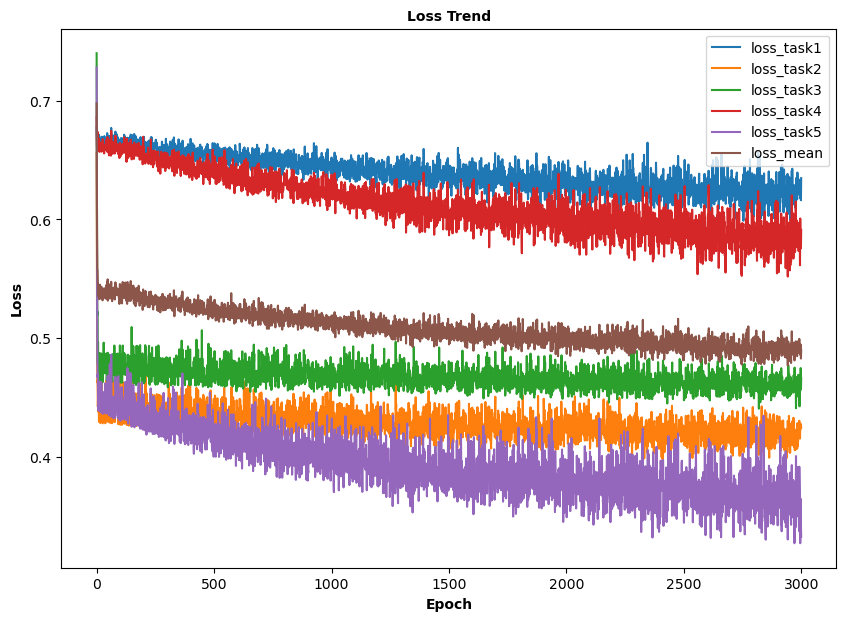

In [61]:
# SVM_df = pd.read_csv("./result/SVM_regression.csv")
# labels = np.array(list(SVM_df["Target"]))
# x = np.array(range(12))
loss_task1 = np.array(list(loss_file["loss_task1"]))
loss_task2 = np.array(list(loss_file["loss_task2"]))
loss_task3 = np.array(list(loss_file["loss_task3"]))
loss_task4 = np.array(list(loss_file["loss_task4"]))
loss_task5 = np.array(list(loss_file["loss_task5"]))
loss_mean = np.array(list(loss_file["loss_mean"]))

fig = plt.figure(figsize=(10, 7))

plt.plot(loss_task1, label="loss_task1")
plt.plot(loss_task2, label="loss_task2")
plt.plot(loss_task3, label="loss_task3")
plt.plot(loss_task4, label="loss_task4")
plt.plot(loss_task5, label="loss_task5")
plt.plot(loss_mean, label="loss_mean")


plt.title("Loss Trend", fontdict={"size":10, "weight":"bold"})
plt.xlabel("Epoch", fontdict={"size":10, "weight":"bold"})
plt.ylabel("Loss", fontdict={"size":10, "weight":"bold"})
# plt.xticks(fontsize=12,ticks=x, labels=labels, rotation=-15)  # 设置x轴刻度字体大小
# plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
# plt.ylim(0, 1)
# plt.grid()
plt.legend()
plt.savefig('./img/loss3.png')
plt.show()

In [62]:
# model.eval()

dataset = TensorDataset(X_test1, y_test1, y_test2, y_test3, y_test4, y_test5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

predict_1, predict_2, predict_3, predict_4, predict_5 = [],[],[],[],[]
real_1, real_2, real_3, real_4, real_5 = [],[],[],[],[]

# Evaluation loop
for batch in loader:
    # Split data into inputs and labels for each task
    X_test1, y_test1, y_test2, y_test3, y_test4, y_test5 = batch
    
    X_test1 = X_test1.to(device)

    y_test1 = y_test1.to(device)
    y_test2 = y_test2.to(device)
    y_test3 = y_test3.to(device)
    y_test4 = y_test4.to(device)
    y_test5 = y_test5.to(device)
    

    with torch.no_grad():
        outputs = model(X_test1)
        # predict value
        predict_1 = predict_1 + torch.argmax(outputs[0], dim=1).cpu().tolist()
        predict_2 = predict_2 + torch.argmax(outputs[1], dim=1).cpu().tolist()
        predict_3 = predict_3 + torch.argmax(outputs[2], dim=1).cpu().tolist()
        predict_4 = predict_4 + torch.argmax(outputs[3], dim=1).cpu().tolist()
        predict_5 = predict_5 + torch.argmax(outputs[4], dim=1).cpu().tolist()

        # real value
        real_1 = real_1 + y_test1.cpu().tolist()
        real_2 = real_2 + y_test2.cpu().tolist()
        real_3 = real_3 + y_test3.cpu().tolist()
        real_4 = real_4 + y_test4.cpu().tolist()
        real_5 = real_5 + y_test5.cpu().tolist()

# Accuracy score
accuracy_1 = accuracy_score(real_1, predict_1)
accuracy_2 = accuracy_score(real_2, predict_2)
accuracy_3 = accuracy_score(real_3, predict_3)
accuracy_4 = accuracy_score(real_4, predict_4)
accuracy_5 = accuracy_score(real_5, predict_5)
        
print("acc_1:",accuracy_1,"acc_2:",accuracy_2,"acc_3:",accuracy_3,"acc_4:",accuracy_4,"acc_5:",accuracy_5)

# Precission score
precision_1 = precision_score(real_1, predict_1)
precision_2 = precision_score(real_2, predict_2)
precision_3 = precision_score(real_3, predict_3)
precision_4 = precision_score(real_4, predict_4)
precision_5 = precision_score(real_5, predict_5)
        
print("pre_1:",precision_1,"pre_2:",precision_2,"pre_3:",precision_3,"pre_4:",precision_4,"pre_5:",precision_5)

# Recall score
recall_1 = recall_score(real_1, predict_1)
recall_2 = recall_score(real_2, predict_2)
recall_3 = recall_score(real_3, predict_3)
recall_4 = recall_score(real_4, predict_4)
recall_5 = recall_score(real_5, predict_5)
        
print("recall_1:",recall_1,"recall_2:",recall_2,"recall_3:",recall_3,"recall_4:",recall_4,"recall_5:",recall_5)

# F1 score
f1_1 = f1_score(real_1, predict_1)
f1_2 = f1_score(real_2, predict_2)
f1_3 = f1_score(real_3, predict_3)
f1_4 = f1_score(real_4, predict_4)
f1_5 = f1_score(real_5, predict_5)
        
print("f1_1:",f1_1,"f1_2:",f1_2,"f1_3:",f1_3,"f1_4:",f1_4,"f1_5:",f1_5)



acc_1: 0.576271186440678 acc_2: 0.8813559322033898 acc_3: 0.8135593220338984 acc_4: 0.6271186440677966 acc_5: 0.8135593220338984
pre_1: 0.75 pre_2: 0.0 pre_3: 0.0 pre_4: 0.6666666666666666 pre_5: 0.8103448275862069
recall_1: 0.1111111111111111 recall_2: 0.0 recall_3: 0.0 recall_4: 0.24 recall_5: 1.0
f1_1: 0.19354838709677416 f1_2: 0.0 f1_3: 0.0 f1_4: 0.3529411764705882 f1_5: 0.8952380952380952


/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
